# Bar reverse integrability

We no longer have a time-independent Hamiltonian. How does the leapfrog integrator perform?

In [1]:
import tstrippy
from astropy import units as u
from astropy import constants as const
from astropy import coordinates as coord
import numpy as np
import matplotlib.pyplot as plt
import datetime

update rc params for nice looking plots

In [2]:
# give each object a color 
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 15,
})

load in the units

In [3]:
unitbasis = tstrippy.Parsers.potential_parameters.unitbasis
unitT=u.Unit(unitbasis['time'])
unitV=u.Unit(unitbasis['velocity'])
unitD=u.Unit(unitbasis['distance'])
unitM=u.Unit(unitbasis['mass'])
unitG=u.Unit(unitbasis['G'])
G = const.G.to(unitG).value

## Prelim info
#### What bar pattern speed is correct? 

We asked ourselves, what is the correct bar pattern speed for the Milky Way? The precise value is up for debate however they say it is between 25-50 km / kpc s. However, *is this the frequency or angular frequency*? A good sanity check was insired from Binney and Tremaine's chapter 6.2 on galactic bars. They demonstrate that observationally, bars have a non-dimensional characteristic number, the co-rotation rate divided by the semi-major axis of the bar: 

$$ \mathcal{R} = \frac{r_{\text{co}}}{a} $$

They state that the fast end of the spectrum has $\mathcal{R} \approx 1$ and slow bars are $\mathcal{R} \gt\gt 1$. 

For Ferrone et al 2023, we choose a bar with a semi-major axis of 4~kpc and a ``fast" bar model of 28 kpc~/~km~s. Below, I will find the co-rotation radius of the galaxy to compute $\mathcal{R}$ 

In [4]:
# pick the bar pattern speed
barpatternspeed = 28*unitV/unitD
MWparams        = tstrippy.Parsers.potential_parameters.pouliasis2017pii()
MWrefframe      = tstrippy.Parsers.potential_parameters.MWreferenceframe()
# pick the bar semi-major axis
abar = 4 * unitD
# construct the rotation curve 
r=np.linspace(0.1,10,1000)
ax,ay,az,phiR=tstrippy.potentials.pouliasis2017pii(MWparams, r, 0*r, 0*r)
F=np.sqrt(ax**2+ay**2+az**2)
# compute the angular velocity
omega = np.sqrt(r*F)/r
# compute the corotation radius
corotation_radius=r[np.argmin(np.abs(omega-barpatternspeed.value))]
# compute the ratio R 
R = corotation_radius/abar.value
y_bar_rotation=omega[np.argmin(np.abs(r-abar.value))]
# compute the wrong corotation radius
corotation_radius_two_pi = r[np.argmin(np.abs(omega-barpatternspeed.value*2*np.pi))]
# compute the wrong ratio R
R_two_pi = corotation_radius_two_pi/abar.value

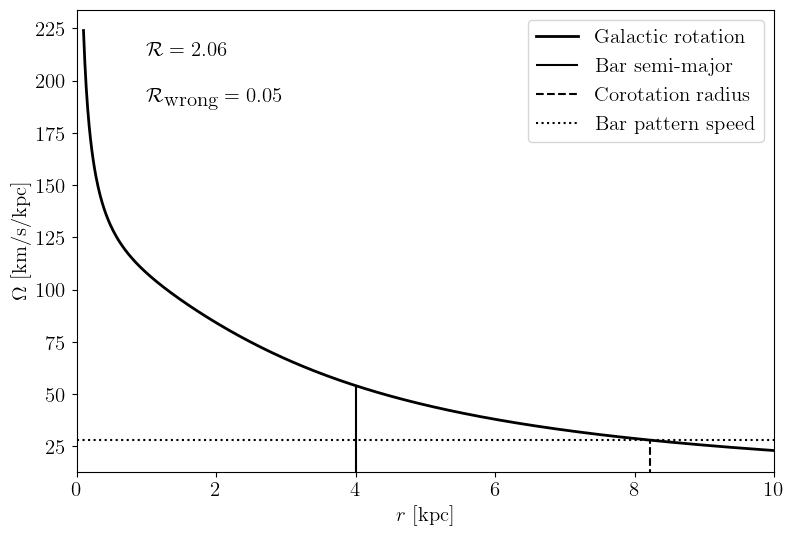

In [5]:
text = r"$\mathcal{R} = %.2f$"%(R)
textWRONG = r"$\mathcal{R}_\textrm{wrong} = %.2f$"%(R_two_pi)
fig,axis=plt.subplots(1,1,figsize=(9,6))
axis.plot(r,omega,label="Galactic rotation",color="k",linewidth=2)
axis.set_ylabel(r"$\Omega$ [km/s/kpc]")
axis.set_xlabel(r"$r$ [kpc]")
ylims=axis.get_ylim()
xlims=axis.get_xlim()
xlims=[0,r.max()]
axis.vlines(abar.value,0,y_bar_rotation,label='Bar semi-major',color="k")
axis.vlines(corotation_radius,0,barpatternspeed.value,label='Corotation radius',linestyles='--',color="k")
axis.hlines(barpatternspeed.value,0,xlims[1],linestyles=':',color="k",label='Bar pattern speed')
axis.text(0.1,0.9,text,transform=axis.transAxes)
axis.text(0.1,0.8,textWRONG,transform=axis.transAxes)
axis.set_ylim(ylims)
axis.set_xlim(xlims)
axis.legend()

So the bar pattern speed is already an angular velocity, not a frequency. An additional factor of 2 $\pi$ would give a bar that is far to fast and unphysical

create a function for standarized plots

In [6]:
def plot_relative_stability(tBack,relativeR,relativaV,colors,rlabel,vlabel,title,timestep,
                            ylims=[1e-20,1e-9]):
    """ Plot the relative stability of the integration of the orbits
    Parameters:
    -----------
    tBack: array
        Array of the integration time in seconds
    relativeR: array
        Array of the relative difference in the position of the objects
    relativeV: array
        Array of the relative difference in the velocity of the objects
    colors: array
        Array of the colors of the objects
    rlabel: string
        Label of the y-axis of the position plot
    vlabel: string
        Label of the y-axis of the velocity plot
    title: string
        Title of the plot
    timestep: float
        Time step of the integration in years
    ylims: array
        Limits of the y-axis of the plots
    
    """
    nGC=len(relativeR)
    fig,axis=plt.subplots(2,1,figsize=(12,8),sharex=True,gridspec_kw={'hspace':0})
    for i in range(nGC):
        axis[0].plot(tBack,relativeR[i],color=colors[i],alpha=0.5)
        axis[1].plot(tBack,relativaV[i],color=colors[i],alpha=0.5)
    for ax in axis:
        ax.set_yscale('log')
        ax.set_xlim(tBack[0],tBack[-1])
        ax.set_ylim(*ylims)
    axis[0].set_ylabel(rlabel,fontsize=25,rotation=0,labelpad=20)
    axis[1].set_ylabel(vlabel,fontsize=25,rotation=0,labelpad=20)
    axis[1].set_xlabel('Integration time [s kpc/ km]')
    y0ticks=axis[0].get_yticks()
    y1ticks=axis[1].get_yticks()
    axis[0].set_yticks(y0ticks[2:-1]);
    axis[1].set_yticks(y1ticks[1:-2]);
    axis[0].set_title(title)
    axis[0].text(0.95,0.95,'Difference between integrating backward and reintegrating forward',transform=axis[0].transAxes,ha='right',va='top')
    axis[0].text(0.95,0.15,"Integration time step: {:.1e}".format(timestep),transform=axis[0].transAxes,ha='right',va='top')
    return fig,axis

create a function that computes the difference in distance and speed between the forward and backward integration

In [7]:
def get_dr_dv_rmean_vmean(backwardOrbit,forwardOrbit):
    """
    Calculate the difference in position and velocity between the backward and forward integration
    """
    dx=backwardOrbit[1]-forwardOrbit[1]
    dy=backwardOrbit[2]-forwardOrbit[2]
    dz=backwardOrbit[3]-forwardOrbit[3]
    dr=np.sqrt(dx**2+dy**2+dz**2)
    dvx=backwardOrbit[4]-forwardOrbit[4]
    dvy=backwardOrbit[5]-forwardOrbit[5]
    dvz=backwardOrbit[6]-forwardOrbit[6]
    dv=np.sqrt(dvx**2+dvy**2+dvz**2)
    xmean=(backwardOrbit[1]+forwardOrbit[1])/2
    ymean=(backwardOrbit[2]+forwardOrbit[2])/2
    zmean=(backwardOrbit[3]+forwardOrbit[3])/2
    vxmean=(backwardOrbit[4]+forwardOrbit[4])/2
    vymean=(backwardOrbit[5]+forwardOrbit[5])/2
    vzmean=(backwardOrbit[6]+forwardOrbit[6])/2
    rmean=np.sqrt(xmean**2+ymean**2+zmean**2)
    vmean=np.sqrt(vxmean**2+vymean**2+vzmean**2)
    return dr,dv,rmean,vmean

def dynamical_time_sorter(x,y,z,vx,vy,vz):
    """
        For making the plots prettier, sort the clusters by a crude estimate of the dynamical time.
    """
    # get an estimate of all dynamical times of the cluster
    r0=np.sqrt(x**2+y**2+z**2)
    v0=np.sqrt(vx**2+vy**2+vz**2)
    Tdyn=r0/v0
    # sort the clusters by dynamical time
    idx=np.argsort(Tdyn)
    return idx

a function to load our integration units

In [8]:
def loadunits():
    # Load the units
    unitbasis = tstrippy.Parsers.potential_parameters.unitbasis
    unitT=u.Unit(unitbasis['time'])
    unitV=u.Unit(unitbasis['velocity'])
    unitD=u.Unit(unitbasis['distance'])
    unitM=u.Unit(unitbasis['mass'])
    unitG=u.Unit(unitbasis['G'])
    G = const.G.to(unitG).value
    return unitT, unitV, unitD, unitM, unitG, G

a function that loads the globular cluster positions and velocities into galactic coordinates

In [9]:
def load_globular_clusters_in_galactic_coordinates(MWrefframe):
    """Extract all initial conditions of the globular clusters and transform them the MW frame"""
    unitT, unitV, unitD, unitM, unitG, G = loadunits()
    GCdata  =   tstrippy.Parsers.baumgardtMWGCs().data
    skycoordinates=coord.SkyCoord(
        ra=GCdata['RA'],
        dec=GCdata['DEC'],
        distance=GCdata['Rsun'],
        pm_ra_cosdec=GCdata['mualpha'],
        pm_dec=GCdata['mu_delta'],
        radial_velocity=GCdata['RV'],)
    galacticcoordinates = skycoordinates.transform_to(MWrefframe)
    x,y,z=galacticcoordinates.cartesian.xyz.to(unitD).value
    vx,vy,vz=galacticcoordinates.velocity.d_xyz.to(unitV).value
    return x,y,z,vx,vy,vz

this function first integrates the clusters backwards in time. It then extacts their final positions and reintegrates them forward in time. The backward and forward orbtis are saved

In [10]:
def bar_clusters(integrationparameters,staticgalaxy,initialkinematics,galacticbar):
    """
    do the backward and forward integration of the vanilla clusters
    """
    currenttime,dt,Ntimestep=integrationparameters
    nObj = initialkinematics[0].shape[0]
    assert(isinstance(currenttime,float))
    assert(isinstance(dt,float))
    assert(isinstance(Ntimestep,int))

    tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
    tstrippy.integrator.setinitialkinematics(*initialkinematics)
    tstrippy.integrator.setintegrationparameters(*integrationparameters)
    tstrippy.integrator.setbackwardorbit()
    tstrippy.integrator.initgalacticbar(*galacticbar)
    xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward=\
        tstrippy.integrator.leapfrogintime(Ntimestep,nObj)
    tBackward=tstrippy.integrator.timestamps.copy()
    tstrippy.integrator.deallocate()

    #### Now compute the orbit forward
    #### IT'S VERY IMPORTANT TO USE tBackward[-1] AS THE CURRENT TIME FOR THE FORWARD INTEGRATION
    #### BEFORE I USED -integrationtime, WHICH CAN BE DIFFERENT BY NSTEP * 1e-16
    #### I.e. A DRIFT IN TIME DUE TO NUMERICAL ERROR, WHICH CAN BECOME SIGNIFICANT FOR INTEGRATING WITH THE BAR
    currenttime=tBackward[-1]

    integrationparameters=[currenttime,dt,Ntimestep]
    x0,y0,z0=xBackward[:,-1],yBackward[:,-1],zBackward[:,-1]
    vx0,vy0,vz0 = -vxBackward[:,-1],-vyBackward[:,-1],-vzBackward[:,-1]
    initialkinematics=[x0,y0,z0,vx0,vy0,vz0]
    tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
    tstrippy.integrator.setintegrationparameters(*integrationparameters)
    tstrippy.integrator.setinitialkinematics(*initialkinematics)
    tstrippy.integrator.initgalacticbar(*galacticbar)
    xForward,yForward,zForward,vxForward,vyForward,vzForward=\
        tstrippy.integrator.leapfrogintime(Ntimestep,nObj)
    tForward=tstrippy.integrator.timestamps.copy()
    tstrippy.integrator.deallocate()

    # flip the backorbits such that the point in the past, 
    # which should be the common starting point, 
    # is the first point for both the forward and backward orbits
    tBackward=tBackward[::-1]
    xBackward,yBackward,zBackward=xBackward[:,::-1],yBackward[:,::-1],zBackward[:,::-1]
    vxBackward,vyBackward,vzBackward=-vxBackward[:,::-1],-vyBackward[:,::-1],-vzBackward[:,::-1]
    backwardOrbit  = [tBackward,xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward]
    forwardOrbit   = [tForward,xForward,yForward,zForward,vxForward,vyForward,vzForward]
    return backwardOrbit,forwardOrbit

## Load parameters



Get the Milky Way potential parameters and reference frame

In [11]:
MWparams        = tstrippy.Parsers.potential_parameters.pouliasis2017pii()
MWrefframe      = tstrippy.Parsers.potential_parameters.MWreferenceframe()

### Reduce the mass of the disks
Since we are adding a bar, we need to reduce the mass of the disks

In [12]:
MWparams[5] = 1120.0 * 2.32*10**7 
MWparams[8] = 1190.0 * 2.32*10**7 

### Add the bar parameters

This is an artificial bar used in Ferrone et al 2023. It is not intended to perfectly model the bar, but rather provide an idea of what a bar can do to stellar streams. It uses a Long-Murali bar. This bar is a needle that has been convolved with a soften kernal to give it a triaxial-shape. 

In [13]:
# mass and size
abar = 4 * unitD
bbar = 1 * unitD
cbar = 0.5 * unitD
Mbar = 990.0*2.32*1e7 * unitM
barname = "longmuralibar"
barparams = [MWparams[0],Mbar.value,abar.value,bbar.value,cbar.value]
# oreitnation and bar pattern speed
theta0= 25 * (np.pi/180) 
omega =  28  * 2*np.pi * unitV / unitD
omega =  28 * unitV / unitD
omega = -omega.value
barpolycoeff=[theta0,omega]

### load the clusters

In [14]:
x,y,z,vx,vy,vz  = load_globular_clusters_in_galactic_coordinates(MWrefframe)

### Integration time parameters

In [15]:
integrationtime =   5e9 * u.yr
timesteps       = [1e7*u.yr,1e6*u.yr,1e5*u.yr,1e4*u.yr]

### pack up arguments

In [16]:
staticgalaxy        = ["pouliasis2017pii", MWparams]
initialkinematics   = [x,y,z,vx,vy,vz]
galacticbar         = ["longmuralibar", barparams, barpolycoeff]

### Integrate

In [17]:
computation_time    = []
realtive_Rs         = []
relative_Vs         = []
ts                  = []
for timestep in timesteps:
    Nsteps      = int(integrationtime.value/timestep.value)
    dt          = timestep.to(unitT).value
    integrationparameters = [0.,dt,Nsteps]
    starttime   =   datetime.datetime.now()
    backwardOrbit,forwardOrbit=\
        bar_clusters(integrationparameters,staticgalaxy,initialkinematics,galacticbar)
    endtime     =   datetime.datetime.now()
    computation_time.append(endtime-starttime)
    dr,dv,rmean,vmean = get_dr_dv_rmean_vmean(backwardOrbit,forwardOrbit)
    idx = dynamical_time_sorter(x,y,z,vx,vy,vz)
    dr,dv,rmean,vmean = dr[idx],dv[idx],rmean[idx],vmean[idx]
    realtive_Rs.append(dr/rmean)
    relative_Vs.append(dv/vmean)
    ts.append(backwardOrbit[0])

Set plot properties

In [18]:
rlabel  = r"$\frac{|\delta\vec{r}|}{\langle r \rangle}$"
vlabel  = r"$\frac{|\delta\vec{v}|}{\langle v \rangle}$"
ylims   = [1e-20,1e1]

get a unique color for each cluster based on the dynamical time

In [19]:
cmap = plt.get_cmap('twilight')
nGC = len(x)
colors = cmap(np.linspace(0, 1, nGC))

#### View the stability results

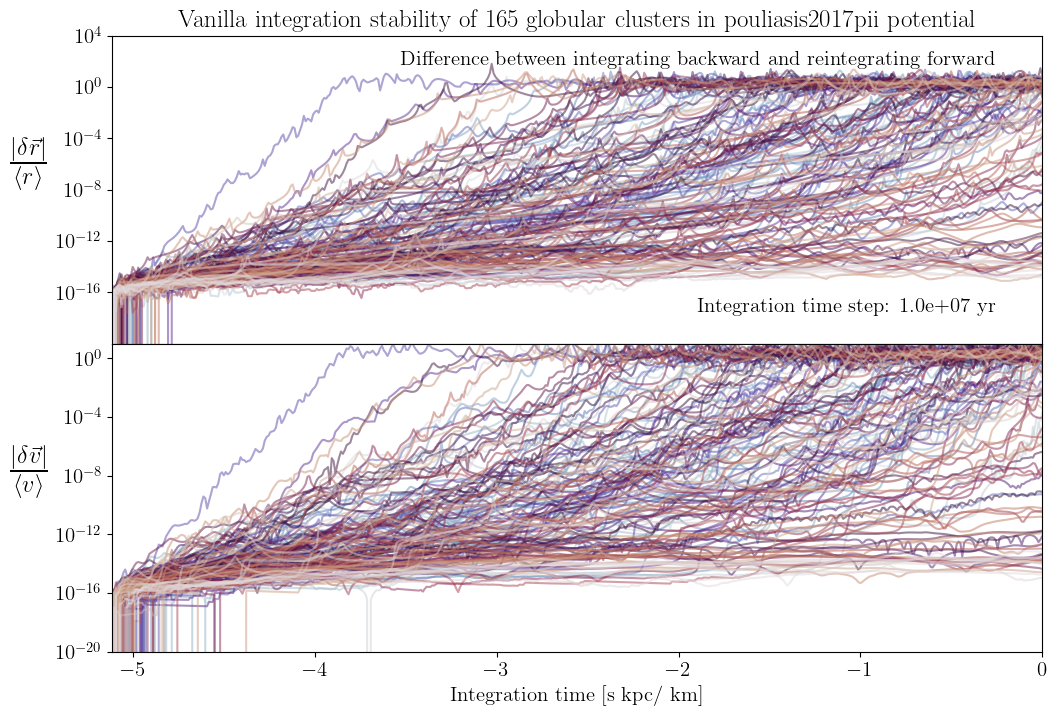

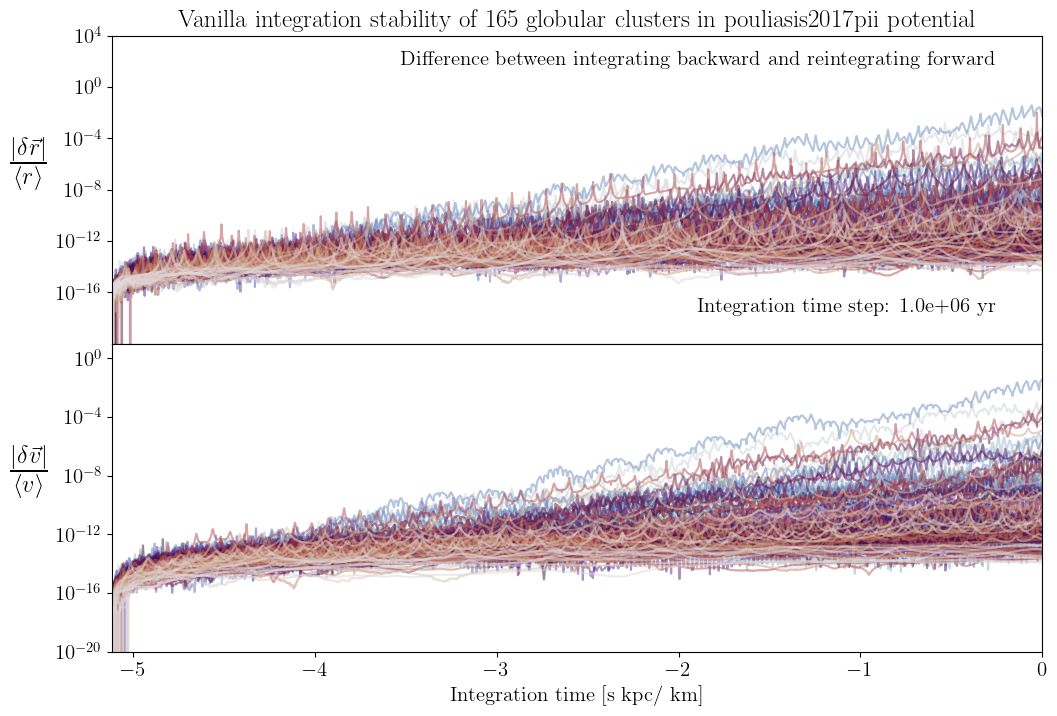

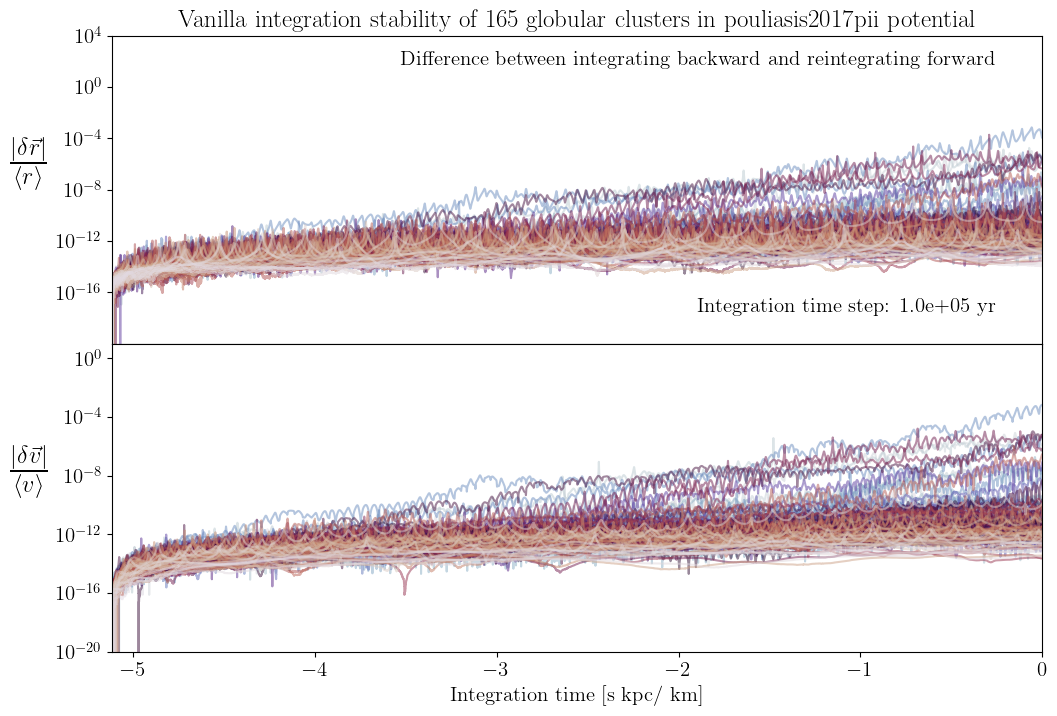

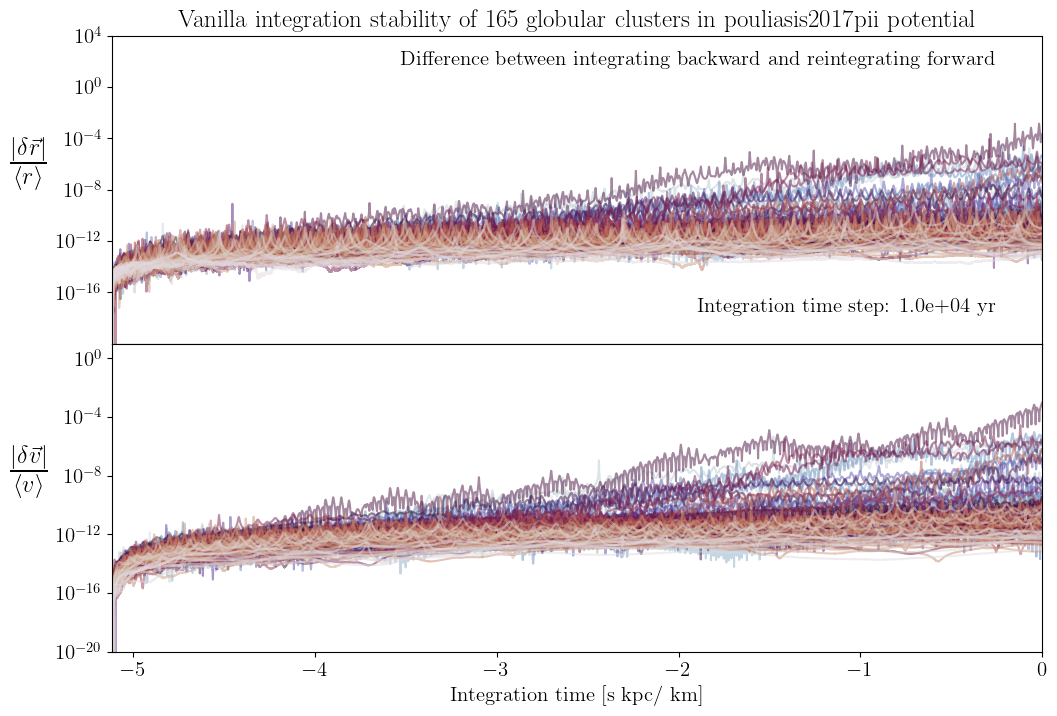

In [20]:
for i in range(len(timesteps)):
    title = r"Vanilla integration stability of {:d} globular clusters in {:s} potential".format(nGC,staticgalaxy[0])
    fig,axis = plot_relative_stability(ts[i],realtive_Rs[i],relative_Vs[i],colors,rlabel,vlabel,title,timesteps[i],ylims)

### View computation time

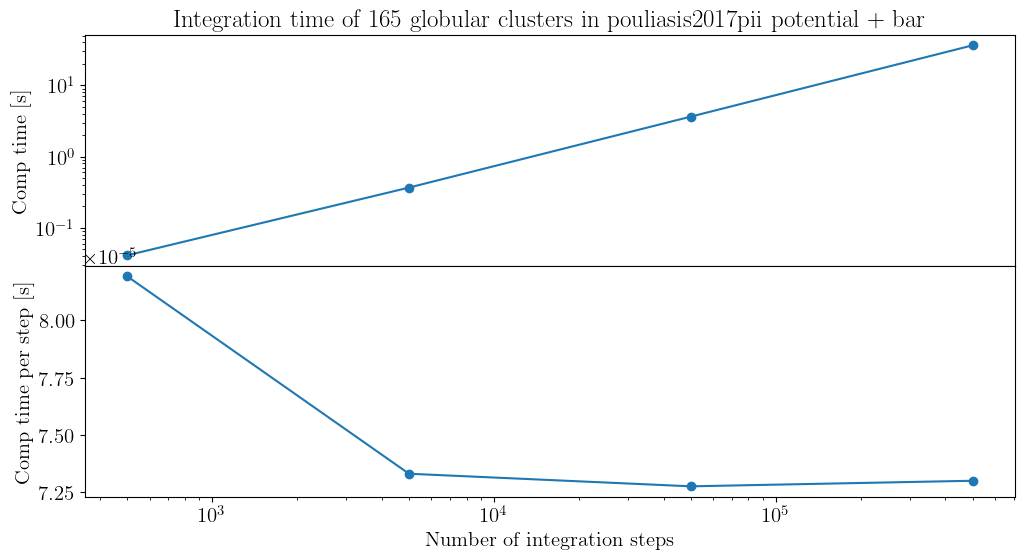

In [21]:
NSTEPS =  [int(integrationtime.to(u.yr).value/timestep.to(u.yr).value) for timestep in timesteps]
time_per_step = [computation_time[i].total_seconds()/NSTEPS[i] for i in range(len(NSTEPS))]
title = r"Integration time of {:d} globular clusters in {:s} potential + bar".format(nGC,staticgalaxy[0])

fig,axis=plt.subplots(2,1,figsize=(12,6),sharex=True,gridspec_kw={'hspace':0})
axis[0].plot(NSTEPS,[ct.total_seconds() for ct in computation_time],marker='o');
axis[1].plot(NSTEPS,time_per_step,marker='o');
axis[0].set_yscale('log');
axis[1].set_xlabel('Number of integration steps');
axis[0].set_title(title)
for ax in axis:
    ax.set_xscale('log');
axis[0].set_ylabel('Comp time [s]');
axis[1].set_ylabel('Comp time per step [s]');

## Study the worst cluster 

In [22]:
GCdata      =   tstrippy.Parsers.baumgardtMWGCs().data
idx         =   idx=np.unravel_index(realtive_Rs[-1].argmax(),realtive_Rs[-1].shape)[0]
targetGC    =   GCdata['Cluster'][idx]
print(targetGC, "was the worst for reverse integration")

NGC6401 was the worst for reverse integration


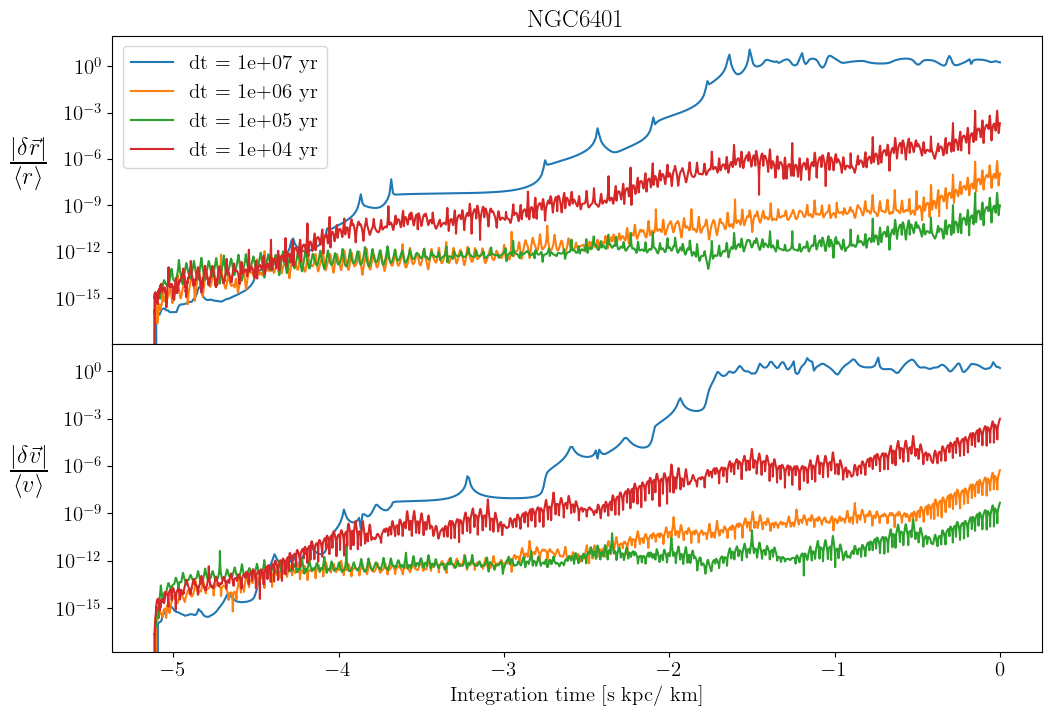

In [23]:
fig,axis=plt.subplots(2,1,figsize=(12,8),sharex=True,gridspec_kw={'hspace':0})
for i in range(len(realtive_Rs)):
    line=axis[0].plot(ts[i],realtive_Rs[i][idx],label='dt = {:.0e}'.format(timesteps[i]));
    axis[1].plot(ts[i],relative_Vs[i][idx],c=line[0].get_color());
for ax in axis:
    ax.set_yscale("log");
axis[0].legend();
axis[1].set_xlabel('Integration time [s kpc/ km]');
axis[0].set_ylabel(rlabel,fontsize=25,rotation=0,labelpad=20);
axis[1].set_ylabel(vlabel,fontsize=25,rotation=0,labelpad=20);
axis[0].set_title("{:s}".format(targetGC));

### XY-plane

If the integration is good, the backward and forward orbits should overlap. 

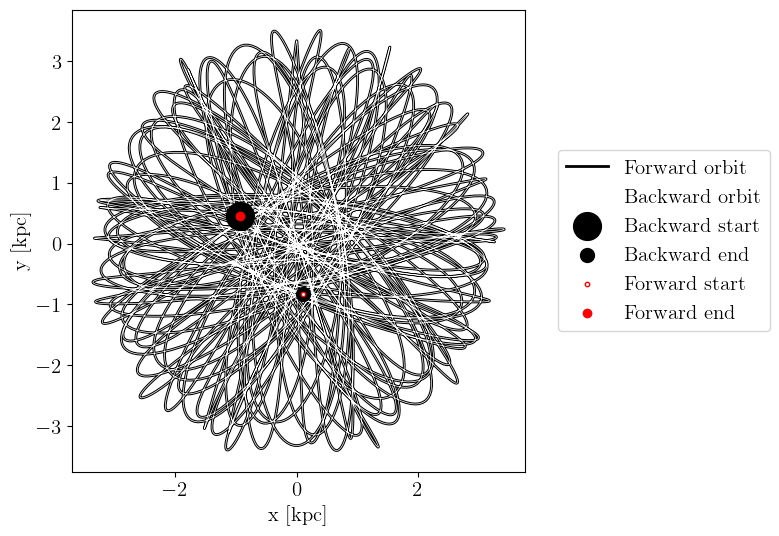

In [24]:
nskip = 100
fig,axis=plt.subplots(1,1,figsize=(7,6),)
axis.plot(forwardOrbit[1][idx][::nskip],forwardOrbit[2][idx][::nskip],linewidth=2,color='k',label='Forward orbit',zorder=0);
axis.plot(backwardOrbit[1][idx][::nskip],backwardOrbit[2][idx][::nskip],linewidth=0.5,color='w',label='Backward orbit',zorder=1);
axis.scatter(backwardOrbit[1][idx][-1],backwardOrbit[2][idx][-1],color='k',label='Backward start',zorder=2,s=400);
axis.scatter(backwardOrbit[1][idx][0],backwardOrbit[2][idx][0],color='k',label='Backward end',zorder=2,s=100);
axis.scatter(forwardOrbit[1][idx][0],forwardOrbit[2][idx][0],color='w',label='Forward start',zorder=3,s=10,edgecolor='r');
axis.scatter(forwardOrbit[1][idx][-1],forwardOrbit[2][idx][-1],color='r',label='Forward end',zorder=4);
axis.set_aspect('equal');
axis.set_xlabel('x [kpc]');
axis.set_ylabel('y [kpc]');
axis.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

The end of the forward integration still arrives at the start of the backward orbit. Which is great!

## The bar frame

Lets look at the orbit in the co-rotation frame. The non-inertial reference frame of the bar. Is this cluster trapped at times?

In [25]:
def transform_to_bar_frame(x,y,z,barpolycoeff,thetime):
    """
    Transform the coordinates to the bar frame
    """
    theta0,omega=barpolycoeff
    theta=theta0+omega*thetime
    xbar=x*np.cos(theta)+y*np.sin(theta)
    ybar=-x*np.sin(theta)+y*np.cos(theta)
    zbar=z
    return xbar,ybar,zbar

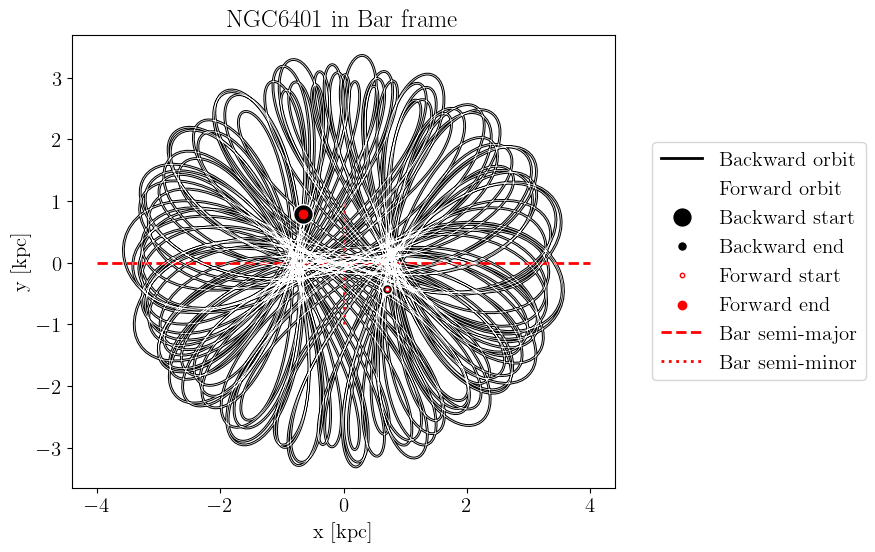

In [26]:
xbarBack,ybarBack,zbarBack = transform_to_bar_frame(backwardOrbit[1][idx,:],backwardOrbit[2][idx,:],backwardOrbit[3][:idx,:],barpolycoeff,backwardOrbit[0][:])
xbarForw,ybarForw,zbarForw = transform_to_bar_frame(forwardOrbit[1][idx,:],forwardOrbit[2][idx,:],forwardOrbit[3][:idx,:],barpolycoeff,forwardOrbit[0][:])
fig,axis=plt.subplots(1,1,figsize=(7,6),)
axis.plot(xbarBack[::nskip],ybarBack[::nskip],linewidth=2,color='k',zorder=0,label='Backward orbit');
axis.plot(xbarForw[::nskip],ybarForw[::nskip],linewidth=0.5,color='w',zorder=1,label='Forward orbit');
axis.scatter(xbarBack[-1],ybarBack[-1],color='k',label='Backward start',zorder=2,s=200,edgecolor='w');
axis.scatter(xbarBack[0],ybarBack[0],color='k',label='Backward end',zorder=2,s=50,edgecolor='w');
axis.scatter(xbarForw[0],ybarForw[0],color='w',label='Forward start',zorder=3,s=10,edgecolor='r');
axis.scatter(xbarForw[-1],ybarForw[-1],color='r',label='Forward end',zorder=4);
axis.plot([-abar.value,abar.value],[0,0],color='r',label='Bar semi-major',linestyle='--',linewidth=2,zorder=0);
axis.plot([0,0],[-bbar.value,bbar.value],color='r',label='Bar semi-minor',linestyle=':',linewidth=2,zorder=0);
axis.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
axis.set_aspect('equal');
axis.set_xlabel('x [kpc]');
axis.set_ylabel('y [kpc]');
axis.set_title('{:s} in Bar frame'.format(targetGC));

### Angular momentum plane for all clusters

In [27]:
# kinetic energy
kinetic_initial = (backwardOrbit[4][:,-1]**2 + backwardOrbit[5][:,-1]**2 + backwardOrbit[6][:,-1]**2) / 2
kinetic_final = (forwardOrbit[4][:,0]**2 + forwardOrbit[5][:,0]**2 + forwardOrbit[6][:,0]**2) / 2
# potential energy from the MW
_,_,_,potential_initial = tstrippy.potentials.pouliasis2017pii(MWparams, backwardOrbit[1][:,-1], backwardOrbit[2][:,-1], backwardOrbit[3][:,-1])
_,_,_,potential_final = tstrippy.potentials.pouliasis2017pii(MWparams, backwardOrbit[1][:,0], backwardOrbit[2][:,0], backwardOrbit[3][:,0])
# potential energy from the bar
# First, find the position of the bar by transforming the cluster to the bar frame
xbar_initial,ybar_initial,zbar_initial = transform_to_bar_frame(backwardOrbit[1][:,-1],backwardOrbit[2][:,-1],backwardOrbit[3][:,-1],barpolycoeff,backwardOrbit[0][-1])
xbar_final,ybar_final,zbar_final = transform_to_bar_frame(backwardOrbit[1][:,0],backwardOrbit[2][:,0],backwardOrbit[3][:,0],barpolycoeff,backwardOrbit[0][0])
_,_,_,potential_bar_initial = tstrippy.potentials.longmuralibar(barparams, xbar_initial, ybar_initial, zbar_initial)
_,_,_,potential_bar_final = tstrippy.potentials.longmuralibar(barparams, xbar_final, ybar_final, zbar_final)
# total energy
E_initial = kinetic_initial + potential_initial + potential_bar_initial
E_final = kinetic_final + potential_final + potential_bar_final
# total angular momentum 
Lz_initial = backwardOrbit[1][:,-1] * backwardOrbit[5][:,-1] - backwardOrbit[2][:,-1] * backwardOrbit[4][:,-1]
Lz_final = forwardOrbit[1][:,0] * forwardOrbit[5][:,0] - forwardOrbit[2][:,0] * forwardOrbit[4][:,0]

Find which clusters are the most changed

In [28]:
dLz = Lz_final - Lz_initial
dE = E_final - E_initial
meanLz = (Lz_final + Lz_initial) / 2
meanE = (E_final + E_initial) / 2
errE=np.abs(dE/meanE)
errL=np.abs(dLz/meanLz)
metric = np.sqrt(errE**2 + errL**2)

color them based on how much they changed in energy and Lz


In [29]:
# give colors according to which were the most changed in energy
cmap = plt.get_cmap('spring')
colors = cmap(metric / metric.max())
colors[:,3]=metric/metric.max()
colors[colors[:,3]>1,3]=1

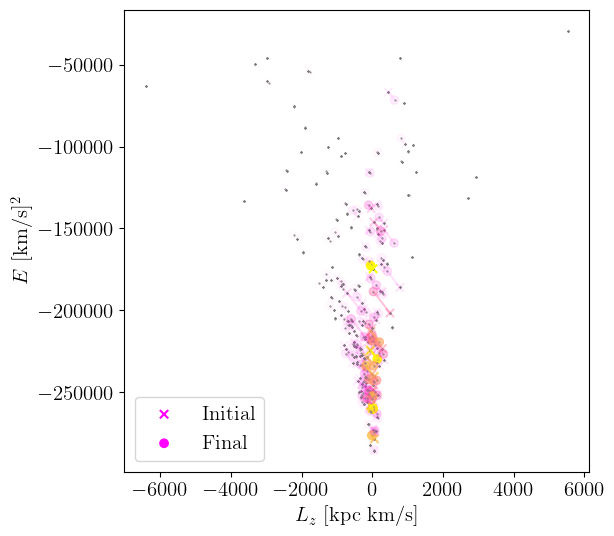

In [30]:
fig,axis=plt.subplots(1,1,figsize=(6,6))
axis.scatter(Lz_initial,E_initial,marker='x',label='Initial',color=colors,)
axis.scatter(Lz_initial,E_initial,marker='x',color="gray",s=1)
axis.scatter(Lz_final,E_final,marker='o',label='Final',color=colors,)
axis.scatter(Lz_final,E_final,marker='.',color="gray",s=1)
axis.set_xlabel(r"$L_z$ [kpc km/s]")
axis.set_ylabel(r"$E$ [km/s]$^2$")
for i in range(len(errE)):
    axis.plot([Lz_initial[i],Lz_final[i]],[E_initial[i],E_final[i]],color=colors[i])

axis.legend()
for lh in axis.legend().legendHandles: 
    lh.set_alpha(1)

Some clusters change in energy. However, since the reverse integrability is good, this changes are physical and not due to numerical error.